
# 🔧 하이퍼파라미터 튜닝 

머신러닝 모델에는 **설정값(파라미터)** 들이 있다.  
예: 트리의 깊이, 학습 속도 등이다.

이 설정을 조금씩 바꿔보면서 **가장 좋은 조합**을 찾는 과정을 말한다.

- `GridSearch`: 가능한 모든 경우를 다 시험해봄  
- `RandomSearch`: 랜덤으로 여러 경우를 뽑아 시험해봄



## 1) 하이퍼파라미터 튜닝이란 무엇인가?

- 하이퍼파라미터는 **모델의 설정값**이다. 예: 트리의 깊이(`max_depth`), 학습률(`learning_rate`) 등이다.  
- 튜닝은 이 설정을 바꾸어 **성능이 가장 좋은 조합**을 찾는 과정이다.  
- 잘못된 설정은 **과적합**(외우기) 또는 **과소적합**(너무 단순)을 만든다. 올바른 설정은 **일반화 성능**을 높인다.



## 2) 교차검증과 함께 설계하기

- 튜닝은 보통 **Stratified K-Fold** 같은 교차검증과 함께 진행한다.  
- **누수 방지 원칙:** 각 폴드의 **학습 부분**에서만 전처리·재표본화·피처선정을 수행하고,
같은 폴드의 **검증 부분**에 적용한다.  
- 최종 모델 선택 후에는 **원본 분포의 테스트 세트**에서 한 번만 평가한다.



## 3) 탐색 방법 요약

| 방법 | 개념 | 장점 | 단점 | 추천 상황 |
|---|---|---|---|---|
| GridSearchCV | 값 목록의 **모든 조합**을 탐색 | 완전탐색 | 계산량 큼 | 후보가 적거나 마지막 미세 조정 |
| RandomizedSearchCV | 범위/분포에서 **무작위 샘플** | 빠름, 넓게 탐색 | 최적값 보장 X | 초반에 넓게 살피기 |
| (참고) 베이지안 최적화 | 다음 탐색 지점을 똑똑하게 고름 | 효율적 | 별도 라이브러리 | 시간이 제한될 때 유용 |

> 실무 팁: **RandomizedSearch → GridSearch** 순서가 효율적이다.



## 4) 검증곡선(Validation Curve)으로 파라미터 감각 익히기

한 파라미터를 바꾸면서 교차검증 점수를 그리면  
**과소적합 ↔ 적정 ↔ 과적합** 영역을 직관적으로 볼 수 있다.

아래 예시는 `DecisionTreeClassifier`의 `max_depth`를 바꿔가며 **F1**(양성 기준) 점수를 본다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import koreanize_matplotlib
from utils import ohe_transform

In [2]:
data = pd.read_csv("./data/salary2.csv")
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data = data.drop_duplicates()
data = data.dropna()
data = data.reset_index(drop=True)
data['class'] = data['class'].apply(lambda x: 1 if x == ' >50K' else 0)
data['class'].value_counts()
X = data.drop('class', axis=1)
y = data['class']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=10)

In [6]:
X_train, X_test = ohe_transform(X_train, X_test)

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    make_scorer, f1_score,
    precision_recall_curve, average_precision_score, auc,
    roc_curve, roc_auc_score)

In [8]:
param_range = np.arange(1, 21)  # 1~20
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

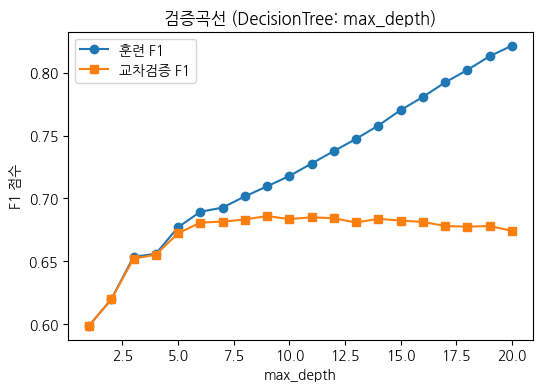

In [9]:
# 검증곡선: max_depth 변화 vs F1 점수
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=cv, scoring=make_scorer(f1_score)
)

# 평균 점수 계산
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# 단일 플롯 (색상 지정 없음)
plt.figure(figsize=(6,4))
plt.plot(param_range, train_mean, marker="o", label="훈련 F1")
plt.plot(param_range, val_mean, marker="s", label="교차검증 F1")
plt.title("검증곡선 (DecisionTree: max_depth)")
plt.xlabel("max_depth")
plt.ylabel("F1 점수")
plt.legend()
plt.show()


# 🌳 검증곡선 해석 (DecisionTree: `max_depth`)

---

## 🔍 1. 그래프 구성 요소

| 항목 | 설명 |
|------|------|
| **x축 (`max_depth`)** | 의사결정나무의 최대 깊이 — 모델 복잡도를 조절하는 하이퍼파라미터 |
| **y축 (F1 점수)** | 정밀도(precision)와 재현율(recall)을 함께 고려한 조화평균 |
| **파란선 (●)** | 훈련 데이터의 F1 점수 |
| **주황선 (■)** | 교차검증 데이터(검증 데이터)의 F1 점수 |

---

## 🧠 2. 그래프 해석 단계별

### (1) `max_depth`가 작을 때 (1~3)
- **훈련 F1**도 낮고, **교차검증 F1**도 낮음  
→ 모델이 너무 단순하여 데이터의 패턴을 충분히 학습하지 못함  
→ **과소적합(underfitting)** 상태

---

### (2) `max_depth`가 4~6일 때
- **훈련 F1**과 **교차검증 F1**이 모두 상승  
- 두 점수가 비슷하고 안정적임  
→ 모델이 적절한 복잡도를 가지며 일반화가 잘 되는 구간  
→ **최적 복잡도(Sweet Spot)**

---

### (3) `max_depth`가 커질수록 (10 이상)
- **훈련 F1**은 계속 상승 (훈련 데이터 완벽하게 맞춤)
- **교차검증 F1**은 점점 하락 (새로운 데이터에는 약함)  
→ **과적합(overfitting)** 발생

---

## ⚖️ 3. 종합 결론

- 최적의 `max_depth`는 **약 5~7** 부근  
- 이 구간에서 훈련/검증 F1이 모두 높고, 차이도 작음  
- 그 이후로는 복잡도 증가에 따라 과적합 심화

---

## 💡 4. 실무적 시사점

| 상황 | 의미 | 대응 전략 |
|------|------|------------|
| 훈련 F1 < 교차검증 F1 | 데이터 부족 또는 과도한 정규화 | 모델 복잡도 ↑ |
| 훈련 F1 ≈ 교차검증 F1 | 좋은 일반화 상태 | ✅ 최적 상태 |
| 훈련 F1 ≫ 교차검증 F1 | 과적합 발생 | 가지치기, `max_depth` 축소, `min_samples_leaf` 증가 |

---

## 📈 5. 요약

> `max_depth`를 늘릴수록 훈련 성능은 좋아지지만,  
> 일정 수준 이후에는 교차검증 성능이 떨어지며 **일반화 능력 저하**가 발생한다.  
> 따라서 **훈련/검증 성능이 균형 잡힌 지점**이 가장 좋은 `max_depth`이다.



## 5) 학습곡선(Learning Curve)으로 데이터/모델 한계 파악

훈련 데이터 양을 늘려가며 **훈련/검증 성능**이 어떻게 변하는지 보면,  
- **데이터를 더 모아야 하는지**,  
- **모델 용량(복잡도)을 바꿔야 하는지**를 알 수 있다.


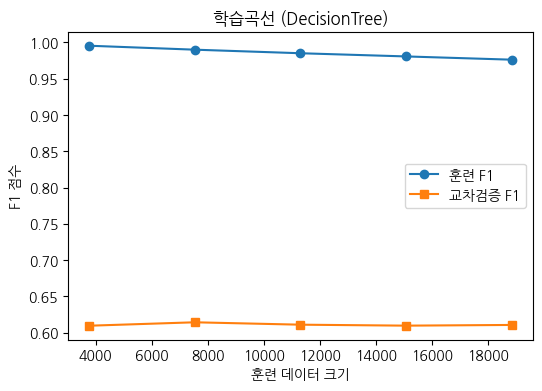

In [10]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    X_train, y_train, cv=cv, scoring=make_scorer(f1_score),
    train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="훈련 F1")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="s", label="교차검증 F1")
plt.title("학습곡선 (DecisionTree)")
plt.xlabel("훈련 데이터 크기")
plt.ylabel("F1 점수")
plt.legend()
plt.show()


# 📊 학습곡선(DecisionTree) 해석

---

## 🔍 1. 그래프 구성 요소

| 항목 | 설명 |
|------|------|
| **x축** | 훈련 데이터의 크기 (훈련 샘플 수 증가) |
| **y축** | F1 점수 (정밀도와 재현율의 조화 평균) |
| **파란선 (●)** | 훈련 데이터에 대한 F1 점수 |
| **주황선 (■)** | 교차검증 데이터(검증 데이터)에 대한 F1 점수 |

---

## 🧠 2. 그래프 해석 단계별

### (1) 훈련 데이터 크기가 작을 때 (~4000)
- **훈련 F1**은 거의 1.0 (거의 완벽한 예측)
- **교차검증 F1**은 약 0.6 수준으로 매우 낮음  
→ 모델이 훈련 데이터에만 완벽히 맞춰지고, 새로운 데이터에는 성능이 낮음  
→ **심한 과적합(overfitting)** 상태

---

### (2) 훈련 데이터가 점점 많아질 때 (4000 → 18000)
- **훈련 F1**은 약간 감소 (모델이 다양한 데이터에 노출되며 완벽히 외우기 어려워짐)
- **교차검증 F1**은 거의 변화 없음 (여전히 낮은 수준 유지)  
→ 데이터가 많아져도 일반화 성능이 개선되지 않음  
→ 즉, **모델 구조 자체가 단순히 과적합되는 경향**을 보임

---

## ⚖️ 3. 종합 결론

| 구분 | 내용 |
|------|------|
| **훈련 성능** | 매우 높음 (F1 ≈ 1.0) |
| **검증 성능** | 매우 낮음 (F1 ≈ 0.6) |
| **훈련/검증 간 간극** | 매우 큼 → **과적합 심각** |
| **결론** | 데이터의 크기보다 모델의 복잡도 제어(`max_depth`, `min_samples_leaf`)가 필요 |

---

## 💡 4. 개선 방향

| 문제 원인 | 해결 전략 |
|------------|------------|
| 의사결정나무가 너무 복잡함 | `max_depth` 줄이기 |
| 일부 노드에 데이터 과소 분할 | `min_samples_split`, `min_samples_leaf` 증가 |
| 데이터 불균형 | `class_weight='balanced'` 옵션 사용 |
| 단일 트리의 한계 | 배깅(RandomForest), 부스팅(LightGBM, XGBoost) 활용 |

---

## 📈 5. 요약

> 훈련 데이터 크기를 늘려도 교차검증 성능이 향상되지 않는 것은  
> 모델이 **데이터 복잡도에 비해 지나치게 복잡**하기 때문이다.  
> 즉, **DecisionTree는 현재 과적합 상태**이며,  
> **하이퍼파라미터 튜닝 또는 앙상블 기법 적용**이 필요하다.



## 6) 어떤 지표로 튜닝할까?

- 불균형 데이터이면 **F1, Recall, PR-AUC**를 권장한다.  
- 비용 민감 문제라면, 업무 비용에 맞춰 **임계값**을 별도로 조정한다.  
- ROC-AUC만 높고 PR-AUC가 낮다면, **희소 양성 문제**일 가능성이 크다.


=== Hold-out 지표 요약 ===
ROC-AUC = 0.737 | PR-AUC = 0.650 | AP = 0.468 | 양성비율(기준선) = 0.254


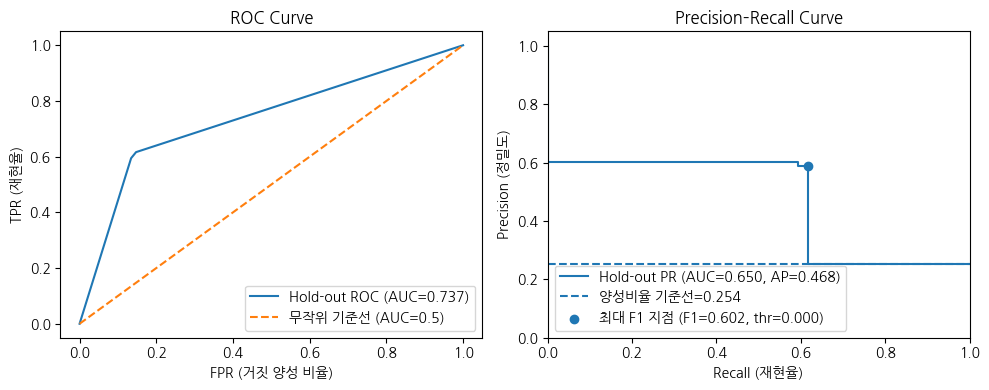

In [11]:
# =========================
# 2) Hold-out용 PR 변수들 계산 (반드시 ROC/PR 전에 정의)
# =========================
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)

# 예측 확률(양성 클래스)
y_score = dt.predict_proba(X_test)[:, 1]

# PR-curve, PR-AUC(AP), 기준선
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)
ap = average_precision_score(y_test, y_score)
baseline = (y_test == 1).mean()

# 최대 F1 지점
f1_vals = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1_vals))
best_recall = recall[best_idx]
best_precision = precision[best_idx]
best_f1 = f1_vals[best_idx]
best_threshold = thresholds[max(0, best_idx - 1)]  # thresholds 길이 보정

# =========================
# 3) ROC-AUC vs PR-AUC 비교 (Hold-out + 선택: CV) - 안전한 포맷팅/플로팅
# =========================
from sklearn.metrics import roc_curve, roc_auc_score

def fmt3(x):
    return f"{x:.3f}" if x is not None else "N/A"

# --- Hold-out ROC ---
roc_auc = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

print("=== Hold-out 지표 요약 ===")
print(f"ROC-AUC = {roc_auc:.3f} | PR-AUC = {pr_auc:.3f} | AP = {ap:.3f} | 양성비율(기준선) = {baseline:.3f}")

# (선택) CV 기반 ROC/PR도 y_score_cv가 있을 때만 계산
roc_auc_cv = None
try:
    if 'y_score_cv' in locals():
        roc_auc_cv = roc_auc_score(y_train, y_score_cv)
        fpr_cv, tpr_cv, _ = roc_curve(y_train, y_score_cv)
        # pr_auc_cv, ap_cv 는 앞의 try 블록에서 이미 계산됐을 수도 있고 없을 수도 있음
except Exception as e:
    print(f"[INFO] CV ROC-curve는 건너뜀: {e}")

# --- 2열 비교 그림: (좌) ROC, (우) PR ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# (좌) ROC Curve
axes[0].plot(fpr, tpr, label=f"Hold-out ROC (AUC={roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", label="무작위 기준선 (AUC=0.5)")
if (roc_auc_cv is not None) and ('fpr_cv' in locals()):
    axes[0].plot(fpr_cv, tpr_cv, label=f"CV ROC (AUC={fmt3(roc_auc_cv)})")
axes[0].set_xlabel("FPR (거짓 양성 비율)")
axes[0].set_ylabel("TPR (재현율)")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

# (우) Precision–Recall Curve
axes[1].step(recall, precision, where="post",
             label=f"Hold-out PR (AUC={pr_auc:.3f}, AP={ap:.3f})")
axes[1].hlines(baseline, 0, 1, linestyles="--",
               label=f"양성비율 기준선={baseline:.3f}")

# CV PR곡선: precision_cv/recall_cv가 있고, pr_auc_cv/ap_cv가 계산된 경우만
if ('precision_cv' in locals()) and ('recall_cv' in locals()):
    label_cv = f"CV PR (AUC={fmt3(pr_auc_cv)}, AP={fmt3(ap_cv)})"
    axes[1].step(recall_cv, precision_cv, where="post", label=label_cv)

axes[1].scatter([best_recall], [best_precision], marker="o", zorder=5,
                label=f"최대 F1 지점 (F1={best_f1:.3f}, thr={best_threshold:.3f})")
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel("Recall (재현율)")
axes[1].set_ylabel("Precision (정밀도)")
axes[1].set_title("Precision–Recall Curve")
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()


# 📊 ROC-AUC & PR-AUC 그래프 해석

---

## 🔍 1. 전체 요약

| 지표 | 값 | 의미 |
|------|------|------|
| **ROC-AUC** | **0.737** | 모델이 무작위보다 훨씬 나은 구분 능력을 가짐 |
| **PR-AUC** | **0.650** | 양성(1) 클래스에 대한 정밀도-재현율 균형이 중간 수준 |
| **AP (Average Precision)** | **0.468** | 전체 임계값에서 평균 정밀도 |
| **양성 비율 (기준선)** | **0.254** | 데이터에서 실제 양성 클래스 비율 (25.4%) |
| **최대 F1 지점** | **F1 = 0.602, threshold = 0.000** | 가장 균형 잡힌 정밀도/재현율 지점 |

---

## 🧠 2. ROC Curve (왼쪽 그래프)

- **TPR(재현율)** vs **FPR(거짓 양성 비율)** 그래프  
- **파란 실선**: 모델의 ROC 곡선  
- **주황 점선**: 무작위 분류기의 기준선 (AUC = 0.5)

### 해석:
- ROC-AUC = **0.737** → 모델이 **양성과 음성을 73.7% 확률로 올바르게 구분**  
- 완벽한 모델(AUC=1.0)과 무작위 모델(AUC=0.5) 사이에 위치  
- **중간 이상 수준의 분류 성능**, 다만 완벽하지 않음  
- 모델이 과적합되지 않았지만, 개선 여지가 있음

---

## 📈 3. Precision-Recall Curve (오른쪽 그래프)

- **x축:** Recall (재현율, 실제 양성 중 맞춘 비율)  
- **y축:** Precision (정밀도, 예측한 양성 중 실제 양성 비율)

### 주요 특징:
- **파란 실선:** 모델의 Precision-Recall 곡선  
- **파란 점:** 최대 F1 점수 지점 (F1 = 0.602)  
- **파란 점선:** 데이터의 양성 비율(0.254)을 나타내는 기준선

### 해석:
- 모델의 **PR-AUC = 0.650** → 불균형 데이터 환경에서 준수한 수준  
- **기준선(0.254)**보다 훨씬 높으므로, **양성 클래스 식별 능력**이 있음  
- 하지만 **정밀도(Precision)**가 낮고 **재현율(Recall)**이 높은 형태로,  
  **양성을 많이 잡지만 오탐도 많을 가능성** 존재

---

## ⚖️ 4. 종합 결론

| 평가 항목 | 분석 |
|------------|------|
| **ROC-AUC (0.737)** | 모델이 전반적으로 양성과 음성을 잘 구분함 |
| **PR-AUC (0.650)** | 불균형 데이터에서도 양호한 수준 |
| **F1 (0.602)** | Precision과 Recall의 균형이 적당함 |
| **개선 방향** | Precision 향상(오탐 감소)을 위한 threshold 조정 또는 모델 튜닝 필요 |

---

## 💡 5. 실무적 시사점

- **ROC-AUC**은 전체 구분 능력, **PR-AUC**은 양성 클래스 탐지 능력에 초점  
- 데이터 불균형이 심할 때는 **PR-AUC를 우선적으로 해석**해야 함  
- 만약 “양성을 놓치면 안 되는” 문제(예: 사기 탐지, 질병 진단)라면  
  → **Recall을 높이고**, Precision 저하를 감수할 수 있음  
- 반대로 “오탐이 위험한” 문제(예: 금융 승인, 알람 시스템)라면  
  → **Precision 중심 조정(threshold ↑)** 필요

---

## 🧾 6. 요약 문장

> ROC-AUC=0.737, PR-AUC=0.650으로,  
> 모델은 무작위보다 훨씬 좋은 분류 성능을 보이지만  
> 여전히 **양성 클래스 예측의 정밀도 개선 여지**가 있다.  
> 현재 상태는 **균형 잡힌 중간 수준 모델**로 평가할 수 있다.


## 7) 하이퍼파라미터 튜닝 RandomSearchCV, GridSearchCV

## RandomizedSearchCV 개념 & 특징

### ✅ RandomizedSearchCV란?

- **탐색할 파라미터 범위**를 미리 지정해두면,  
  그 안에서 **일정 횟수(`n_iter`)**만큼 **랜덤하게 조합을 뽑아서** 성능을 평가하는 방법이다.

---

### ✅ 장점

- **파라미터 조합이 많을 때** 빠르게 좋은 조합을 찾기 좋다.
- 모든 조합을 다 보지는 않지만,  
  **시간 대비 효율(성능/시간 비율)이 좋다.**
- 연속형 분포(예: `uniform`, `randint`)에서도 샘플링 가능해서  
  **넓은 범위를 대략적으로 탐색**할 때 유리하다.

---

### ✅ 단점

- **모든 조합을 탐색하지 않기 때문에**,  
  이론적으로는 **진짜 최적 조합**을 놓칠 수도 있다.
- `n_iter`를 너무 작게 잡으면  
  탐색이 **불충분**해서 성능 향상이 제한될 수 있다.

---


## 8) 알고리즘별 파라미터 세팅 요령 (실무 요약)

### 8.1 DecisionTreeClassifier
- **핵심:** 트리 깊이·리프 크기로 과적합을 억제한다.
- 주요 파라미터
  - `max_depth`: 트리 최대 깊이. 3~12에서 시작한다.
  - `min_samples_split`: 분할 최소 샘플 수. 2, 5, 10, 20.
  - `min_samples_leaf`: 리프 최소 샘플 수. 1, 2, 5, 10.
  - `class_weight`: 불균형이면 `'balanced'`.
- 스타터 그리드(예시)
  ```python
  {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
  }
  ```

### 8.2 RandomForestClassifier
- **핵심:** 충분한 트리 수 + 깊이/리프 제어로 안정화한다.
- 주요 파라미터
  - `n_estimators`: 300~1000에서 시작한다.
  - `max_depth`: 8~30 또는 None.
  - `min_samples_split`, `min_samples_leaf`: 2~20 범위.
  - `max_features`: "sqrt", 0.5, 0.7 등(특성 수에 따라 조정).
  - `class_weight`: 불균형이면 `'balanced'`.
- 스타터 그리드(예시)
  ```python
  {
    "n_estimators": [300, 500, 800],
    "max_depth": [None, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None]
  }
  ```

### 8.3 XGBoost (XGBClassifier)
- **핵심:** 깊이/학습률/규제로 과적합을 관리하고, 불균형은 `scale_pos_weight`로 보정한다.
- 주요 파라미터
  - `n_estimators`: 300~1000(early_stopping과 함께).
  - `learning_rate`: 0.02~0.2.
  - `max_depth`: 3~10.
  - `min_child_weight`: 1~10.
  - `subsample`, `colsample_bytree`: 0.6~1.0.
  - `reg_alpha`(L1), `reg_lambda`(L2): 0~10.
  - `scale_pos_weight`: (음성 수 / 양성 수) 근사값.
- 스타터 그리드(예시)
  ```python
  {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1.0, 3.0, 5.0]
  }
  ```

### 8.4 LightGBM (LGBMClassifier)
- **핵심:** 잎 수와 리프 최소 데이터, 학습률/규제가 중요하다. 불균형은 `is_unbalance` 또는 `class_weight`로 처리한다.
- 주요 파라미터
  - `num_leaves`: 31~127에서 시작한다.
  - `max_depth`: -1(None) 또는 5~20.
  - `learning_rate`: 0.02~0.2.
  - `n_estimators`: 300~1000.
  - `min_data_in_leaf`: 20~100.
  - `feature_fraction`, `bagging_fraction`, `bagging_freq`: 0.6~1.0 / 0.6~1.0 / 0~5.
  - `lambda_l1`, `lambda_l2`: 0~10.
  - `is_unbalance=True` 또는 `class_weight`: 둘을 동시에 쓰지는 않는다.
- 스타터 그리드(예시)
  ```python
  {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 7, 11, 15],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "min_data_in_leaf": [20, 40, 80],
    "feature_fraction": [0.7, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.9, 1.0],
    "bagging_freq": [0, 1, 3],
    "lambda_l1": [0, 0.1, 1.0],
    "lambda_l2": [0, 0.1, 1.0]
  }
  ```

### 8.5 CatBoost (CatBoostClassifier)
- **핵심:** 카테고리 자동 처리가 강점이다. 불균형은 `class_weights`로 조정한다.
- 주요 파라미터
  - `iterations`(=n_estimators): 300~1000.
  - `learning_rate`: 0.03~0.2.
  - `depth`: 4~10.
  - `l2_leaf_reg`: 1~10.
  - `subsample`: 0.6~1.0.
  - `class_weights`: [w_neg, w_pos] 형태(비율 역수 근사).
- 스타터 그리드(예시)
  ```python
  {
    "iterations": [300, 600, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "subsample": [0.7, 0.9, 1.0]
  }
  ```



## 9) 클래스 불균형 대응 요약

| 알고리즘 | 권장 설정 요약 |
|---|---|
| DecisionTree / RandomForest | `class_weight='balanced'` |
| XGBoost | `scale_pos_weight ≈ 음성수/양성수` |
| LightGBM | `is_unbalance=True` 또는 `class_weight` |
| CatBoost | `class_weights=[w_neg, w_pos]` |

> `scale_pos_weight`와 `class_weight` 류는 보통 **동시에 중복 사용하지 않는다**.


# 1) DecisionTree

# 2) RandomForest

# 3) XGBoost

# 4) LightGBM

# 5) CatBoost

## GridSearchCV 개념 & 특징

### ✅ GridSearchCV란?

- 사용자가 지정한 **모든 하이퍼파라미터 조합을 전부 탐색**하는 방법이다.  
- 즉, 각 파라미터마다 후보 값들을 격자(grid)처럼 나열해 두고,  
  그 **모든 조합을 하나씩 다 학습 + 평가**한다.

---

### ✅ 장점

- 지정한 후보 집합 내에서는  
  **“완전 탐색(브루트 포스)”**을 하기 때문에  
  그 범위 안에서 **최적 조합을 놓치지 않는다.**
- 파라미터 수와 후보 개수가 **적당히 적다면**,  
  해석과 재현성이 좋다.

---

### ✅ 단점

- 파라미터 개수와 후보 값 개수가 조금만 늘어나도  
  **조합 수가 기하급수적으로 증가**한다.  
  - 예: 파라미터 3개, 각각 후보 10개 → 10 × 10 × 10 = 1000조합
- 모델 학습 비용이 큰 경우,  
  **시간이 너무 많이 걸릴 수 있다.**
- 넓은 범위를 탐색하기에는 **비효율적**이며,  
  보통은 **“좁고 정교한 범위”**에 적합하다.

# GridSearchCV 예제 Lightgbm


## 10) 튜닝 체크리스트

- [ ] 지표 선택: F1/Recall/PR-AUC 등 문제 성격과 일치하는가  
- [ ] 교차검증 설계: Stratified/Group/TimeSeries 등 상황에 맞는가  
- [ ] 누수 방지: 폴드 학습 안에서만 전처리/재표본화/피처선정 수행  
- [ ] 탐색 전략: Randomized → Grid로 효율적 탐색  
- [ ] 과적합 방지: 깊이/리프/규제/서브샘플링 조정  
- [ ] 불균형 처리: class_weight/scale_pos_weight/is_unbalance/class_weights 적용  
- [ ] 임계값/캘리브레이션: 필요 시 점수 보정/운영점 최적화  
- [ ] 최종 검증: 원본 분포의 테스트 세트에서 단 한 번 확인
